In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set random seed for reproducibility
torch.manual_seed(0)

# Torch version
torch.__version__

'2.0.0+cu118'

In [2]:
# MNIST dataset

from torchvision import datasets, transforms
import torchvision

# Split MNIST into train, validation, and test sets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# Split train_data into train and validation sets
val_data = torch.utils.data.Subset(train_data, range(50000, 51000))

# Reduce the size of the training set to 5,000
train_data = torch.utils.data.Subset(train_data, range(0, 5000))


In [3]:
# Create data loaders
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
img, target = next(iter(train_loader))
print(img.shape)
print(target.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


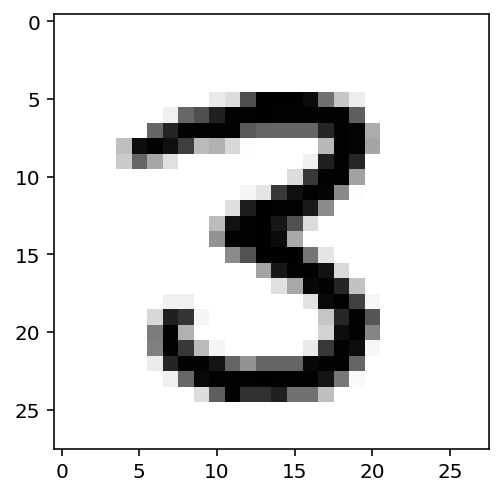

In [5]:
plt.imshow(img[0].numpy().squeeze(), cmap='gray_r');

In [6]:
target

tensor([3, 4, 1, 8, 9, 3, 9, 8, 4, 8, 3, 0, 0, 7, 7, 1, 6, 6, 9, 7, 4, 3, 3, 4,
        5, 7, 3, 2, 8, 4, 8, 2, 8, 3, 1, 4, 2, 1, 4, 8, 5, 3, 5, 1, 8, 7, 3, 7,
        7, 2, 0, 3, 1, 3, 7, 0, 7, 1, 7, 6, 4, 1, 8, 0])

In [7]:
# Store the labels and Images in TensorBoard

from torch.utils.tensorboard import SummaryWriter

# Clean up any old runs
!rm -rf runs

# Default `log_dir` is "runs"
writer = SummaryWriter('runs/mnist')

# Add images to tensorboard in the form of a grid in batches of 64
dataiter = iter(DataLoader(train_data, batch_size=64, shuffle=True))

# Add a slider in tensorboard to iterate through the batches
for i in range(10):
    images, labels = next(dataiter)
    images = torchvision.utils.make_grid(images)
    # Add images with labels to tensorboard
    writer.add_image(f'mnist_images_{i}', images, global_step=i)

In [8]:
# Define model for 10-class MNIST classification

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        z1 = self.fc1(x)
        a1 = F.relu(z1)
        z2 = self.fc2(a1)
        a2 = F.relu(z2)
        z3 = self.fc3(a2) # logits
        return z3

In [10]:
model = MNISTClassifier()

torch.Size([64, 784])
tensor([-0.1859, -0.1648,  0.0156,  0.0309,  0.1785, -0.1567, -0.0472,  0.1143,
        -0.0400, -0.0006])
tensor([0.0846, 0.0864, 0.1035, 0.1051, 0.1218, 0.0871, 0.0972, 0.1143, 0.0979,
        0.1019])


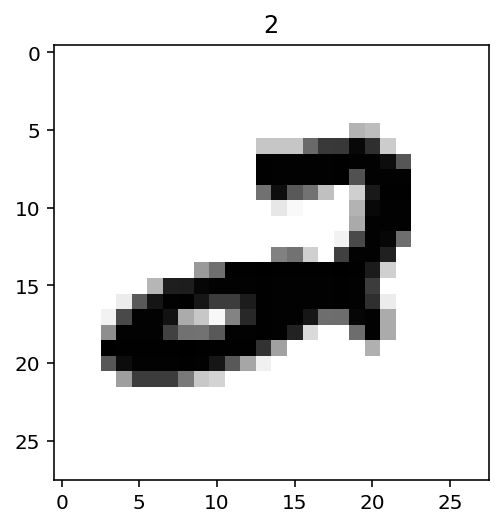

In [11]:
# Forward pass through the model



saved_img, saved_target = next(iter(train_loader))
saved_img = saved_img.view(saved_img.shape[0], -1)
print(saved_img.shape)

plt.imshow(saved_img[0].reshape(28, 28), cmap='gray_r')
plt.title(saved_target[0].item())


with torch.no_grad():
    out = model(saved_img.view(saved_img.shape[0], -1))



print(out[0])

# Softmax
probas = F.softmax(out, dim=1)
print(probas[0])

In [12]:
probas[0:1]

tensor([[0.0846, 0.0864, 0.1035, 0.1051, 0.1218, 0.0871, 0.0972, 0.1143, 0.0979,
         0.1019]])

In [13]:
# Predicted label before training

pred = torch.argmax(probas[0:1], dim=1).item()
print(f"Prediction:  {pred}, True label: {saved_target[0].item()}")

Prediction:  4, True label: 2


In [14]:
model.fc1.weight.shape, model.fc1.bias.shape

(torch.Size([64, 784]), torch.Size([64]))

In [15]:
# Number of parameters in fc1
print("fc1", model.fc1.weight.numel() + model.fc1.bias.numel())

# Number of parameters in fc2
print("fc2", model.fc2.weight.numel() + model.fc2.bias.numel())

# Number of parameters in fc3
print("fc3", model.fc3.weight.numel() + model.fc3.bias.numel())

fc1 50240
fc2 2080
fc3 330


In [16]:
# Get total number of parameters
print("Total number of parameters:", sum(p.numel() for p in model.parameters()))

Total number of parameters: 52650


In [54]:
len(train_loader)

79

In [52]:
# Forward pass through the model and writing to tensorboard

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

num_epochs = 1
for epoch in range(num_epochs):
    for batch_idx, (data_test, target) in enumerate(train_loader):
        # Reshape data to input to the network
        data_test = data_test.view(data_test.shape[0], -1)
        # Forward pass
        output = model(data_test)
        loss = criterion(output, target)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iteration_num = epoch * len(train_loader) + batch_idx
        
        # Write to tensorboard
        writer.add_scalar('Loss/train', loss.item(), iteration_num)
        writer.add_scalar('Accuracy/train', (output.argmax(dim=1) == target).float().mean(), iteration_num)

        # Find test loss and accuracy
        runing_loss = 0.0
        running_acc = 0.0
        with torch.no_grad():
            for data_test, target_test in val_loader:
                data_test = data_test.view(data_test.shape[0], -1)
                output_test = model(data_test)
                loss_test = criterion(output_test, target_test)
                runing_loss += loss_test.item()
                running_acc += (output_test.argmax(dim=1) == target_test).float().mean()
        writer.add_scalar('Loss/validation', runing_loss / len(val_loader), iteration_num)
        writer.add_scalar('Accuracy/validation', running_acc / len(val_loader), iteration_num)

        if batch_idx % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/1], Step [0/79], Loss: 2.3027


In [60]:
# Prediction on the saved image

with torch.no_grad():
    out = model(saved_img[0:1])
    probas = F.softmax(out, dim=1)
    pred = torch.argmax(probas, dim=1).item()
    print(pred, saved_target[0].item())

1 1


In [98]:
# Create a HParam dictionary for batch size and learning rate for tensorboard

b_sizes = [32, 64, 512]
lrs = [0.001, 0.01, 0.1]


num_epochs  = 1
for epoch in range(num_epochs):
    for b_size in b_sizes:
        train_loader = DataLoader(train_data, batch_size=b_size, shuffle=True)
        model = MNISTClassifier()
        for lr in lrs:
            print(f"Batch size: {b_size}, Learning rate: {lr}")
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Reshape data to input to the network
                data = data.view(data.shape[0], -1)
                # Forward pass
                output = model(data)
                loss = criterion(output, target)
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                

                # Write loss as scalar to Tensorboard and hyperparameters to HParams
                writer.add_scalar('training loss',
                                loss.item(),
                                epoch * len(train_loader) + batch_idx)
                writer.add_hparams({'lr': lr, 'bsize': b_size},
                                { 'hparam/loss': loss.item()})
                

    

Batch size: 32, Learning rate: 0.001
Batch size: 32, Learning rate: 0.01
Batch size: 32, Learning rate: 0.1
Batch size: 64, Learning rate: 0.001
Batch size: 64, Learning rate: 0.01
Batch size: 64, Learning rate: 0.1
Batch size: 512, Learning rate: 0.001
Batch size: 512, Learning rate: 0.01
Batch size: 512, Learning rate: 0.1
